# ML Pipeline

This notebook contains the ML Pipeline for the model training

## Libraries and imports

In [1]:
import sys
sys.path.append('..')
from scripts.utils import initialize_bucket, plot_importance

from datetime import date

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, explained_variance_score,mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import shap

import pickle
import json

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
pd.set_option("display.max_columns", 400)

credentials_path = '../datascience-capstone-project-05b1642f45c3.json'

In [3]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/05_datasets/df_base_dataset.parquet"
df =  pd.read_parquet(path)

path = "gs://storage-barsianize/05_datasets/df_to_pred.parquet"
df_to_pred =  pd.read_parquet(path)

## Methods and functions

### Build and train pipelines

In [4]:
def build_pipelines(regressors, transformers):
    """Builds a dictionary of pipelines combining regressors and transformers.

    Args:
        regressors (Dict[str, BaseEstimator]): A dictionary of regressor algorithms, where keys are algorithm names
            and values are the corresponding regressor objects.
        transformers (Dict[str, TransformerMixin]): A dictionary of transformer objects, where keys are transformer names
            and values are the corresponding transformer objects.

    Returns:
        Dict[str, Pipeline]: A dictionary of pipelines, where keys are combinations of algorithm and transformer names
            and values are the corresponding pipeline objects.

    Example:
        regressors = {'XGB': XGBRegressor(), 'RF': RandomForestRegressor()}
        transformers = {'Scaler': StandardScaler(), 'Encoder': OneHotEncoder()}
        pipelines = build_pipelines(regressors, transformers)
    """    
    pipelines = {}

    for transformer in transformers:
        for algorithm,regressor in regressors.items():
            pipeline = Pipeline([
                ('preprocessing', transformer),
                ('reg',regressor)
            ])
            pipelines[algorithm + '_' + str(transformer)] = pipeline

    return pipelines

In [5]:
def build_models(regressors, parameters_dict, transformers):
    """Builds and evaluates pipelines with multiple regressors using grid search.

    This function creates pipelines for each combination of provided regressors and transformers,
    performs grid search with cross-validation to find the best hyperparameters, and returns a
    dictionary of trained GridSearchCV objects.

    Args:
        regressors (dict): A dictionary of regressor names as keys and regressor objects as values.
        parameters_dict (dict): A dictionary of algorithm names as keys and lists of hyperparameter
                               grids as values.
        transformers (list): A list of transformer objects to preprocess the data before fitting.

    Returns:
        dict: A dictionary containing trained GridSearchCV objects with algorithm and transformer names
              as keys.

    Example:
        from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
        from sklearn.preprocessing import StandardScaler, MinMaxScaler

        regressors = {
            'RandomForest': RandomForestRegressor(),
            'GradientBoosting': GradientBoostingRegressor()
        }

        parameters_dict = {
            'RandomForest': [{'n_estimators': [50, 100], 'max_depth': [None, 10]},
                             {'n_estimators': [100, 200], 'max_depth': [10, 20]}],
            'GradientBoosting': [{'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]},
                                 {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.2]}]
        }

        transformers = [StandardScaler(), MinMaxScaler()]

        models = build_models(regressors, parameters_dict, transformers)
    """
    pipelines = build_pipelines(regressors, transformers)

    cvs = {}

    for transformer in transformers:
        for algorithm, parameters in parameters_dict.items():
            # Create grid search object
            cv = GridSearchCV(pipelines[algorithm + '_' + str(transformer)], cv=5, param_grid=parameters, scoring='r2')
            cvs[algorithm + '_' + str(transformer)] = cv

    return cvs

In [6]:
def display_and_store_results(X, y, y_test, y_pred, model, algorithm, sufix):
    """
    Display evaluation metrics and store results for a given model.

    This function performs cross-validation on a given model and displays the evaluation metrics including R-squared score,
    mean squared error, explained variance score, and mean absolute percentage error. It also prints the best parameters
    found during cross-validation. The results are stored in JSON and pickle format files.

    Parameters:
        X (pd.DataFrame): Feature matrix for training.
        y (pd.Series): Target variable for training.
        y_test (array-like): True target values for testing.
        y_pred (array-like): Predicted target values for testing.
        model: A trained model object with a 'best_params_' attribute.
        algorithm (str): The name of the algorithm used.
        sufix (str): An optional suffix to include in file names.

    Returns:
        float: R-squared score on the test data.

    """

    # define the cross-validation method (e.g. KFold with 5 folds)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # define the evaluation metrics (r2 score and mean squared error)
    scoring = {'r2': make_scorer(r2_score), 
               'mse': make_scorer(mean_squared_error),
               'xve': make_scorer(explained_variance_score),
               'MAPE': make_scorer(mean_absolute_percentage_error)}
    # perform cross-validation and get the scores
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    print(scores)
    scores['fit_time']  = scores['fit_time'].tolist() 
    scores['score_time']= scores['score_time'].tolist() 
    scores['test_r2']   = scores['test_r2'].tolist() 
    scores['test_mse']  = scores['test_mse'].tolist()
    scores['test_xve']  = scores['test_xve'].tolist()
    scores['test_MAPE'] = scores['test_MAPE'].tolist()

    print('CV R2 score:', np.mean(scores['test_r2']))
    print('CV MSE:', np.mean(scores['test_mse']))

    performance = {}

    test_score_r2 = r2_score(y_test, y_pred)
    test_score_mse = mean_squared_error(y_test, y_pred)
    test_score_xvs = explained_variance_score(y_test, y_pred)
    test_score_mape = mean_absolute_percentage_error(y_test, y_pred)

    print('test r2:', test_score_r2)
    print('test mse:', test_score_mse)
    print('test explained_variance_score:', test_score_xvs)
    print('test MAPE:', test_score_mape)

    performance['cv_scores'] = scores
    performance['test_scores'] = {}
    performance['test_scores']['r2'] = test_score_r2
    performance['test_scores']['mse'] = test_score_mse
    performance['test_scores']['explained_variance_score'] = test_score_xvs
    performance['test_scores']['MAPE'] = test_score_mape
    
    print('___________________________________')
        
    print("\nBest Parameters:", model.best_params_)
    print('##################################')

    performance = {
        'algorithm':algorithm,
        'best_params':model.best_params_,
        'performance':performance,
        'features':X.columns.to_list()
    }

    patch = '../data/03_models/out/'
    filename = patch + f'{str(date.today())}_{algorithm}'

    # return performance
    if sufix != '':
        sufix_ = '_' + sufix
    else:
        sufix_ = sufix

    json.dump(performance, open(filename+f'_results{sufix_}.json', 'w'))   
    pickle.dump(model.best_estimator_, open(filename+f'{sufix_}.pkl', 'wb'))

    return test_score_r2

In [7]:
def train_models(df, params_path, label, regressors, transformers, cols_to_drop=None, cols_to_train=None, sufix=""):
    """Train multiple regression models using different algorithms.

    Args:
        df (pandas.DataFrame): The DataFrame containing the dataset.
        params_path (str): The path to the JSON file containing hyperparameters for models.
        label (str): The name of the target column.
        regressors (list): List of regression algorithms to use.
        transformers (list): List of transformers to apply to the dataset.
        cols_to_drop (list, optional): List of columns to drop from the input DataFrame. Defaults to None.
        cols_to_train (list, optional): List of columns to use for training. Defaults to None.
        sufix (str, optional): Suffix to add to the results' filenames. Defaults to "".

    Returns:
        dict: A dictionary containing trained regression models.
    """
    # separating the train and target features
    if cols_to_train == None:
        X = df.drop(cols_to_drop, axis=1)
    elif cols_to_train != None:
        print('here we go again')
        X = df[cols_to_train]
    else:
        raise

    y = df[label]

    with open(params_path) as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in parameters.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

    models = build_models(regressors,parameters,transformers)

    for algorithm, model in models.items():
        # X, y = load_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

        print(algorithm)        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = display_and_store_results(X, y, y_test, y_pred, model, algorithm, sufix)
        print(algorithm, r2)

    return models

### Load Models and assess results

In [8]:
def load_model(path, model_name):
    """Load a trained model and associated preprocessing transformer.

    This function loads a trained machine learning model and identifies the appropriate
    estimator (LightGBM Regressor or XGBoost Regressor) from the pipeline steps. It also
    identifies any preprocessing transformers used in the pipeline.

    Args:
        path (str): The path to the directory containing the model file.
        model_name (str): The name of the model file.

    Returns:
        tuple: A tuple containing the loaded estimator and the preprocessing transformer.

    Raises:
        FileNotFoundError: If the specified model file does not exist.
    """
    with open(path + model_name, 'rb') as file:
        model = pickle.load(file)

    loaded_model = None
    for step_name, step_model in model.named_steps.items():
        if isinstance(step_model, LGBMRegressor):
            loaded_model = step_model
            break
        elif isinstance(step_model, XGBRegressor):
            loaded_model = step_model
            break
        elif step_name == 'preprocessing':
            transformer = step_model

    return loaded_model, transformer

In [9]:
def make_predictions(path, model_name, results_file, X_to_pred):
    """Make predictions using a trained model and return necessary components.

    This function loads a trained pipeline model and other relevant components,
    and then uses the model to predict target values for the provided data.

    Args:
        path (str): The path to the directory where the model and results file are located.
        model_name (str): The filename of the trained model in pickle format.
        results_file (str): The filename of the JSON results file containing features information.
        X_to_pred (pandas.DataFrame): The input data for which predictions need to be made.

    Returns:
        tuple: A tuple containing the following items:
            - predictions (numpy.ndarray): Predicted target values for the input data.
            - pipeline (sklearn.pipeline.Pipeline): The loaded pipeline model.
            - model: The trained machine learning model.
            - transformer: The data transformer used in the pipeline.
            - features (list): List of selected feature names used for predictions.

    Raises:
        FileNotFoundError: If the specified model file or results file does not exist.

    Example:
        # Assuming the trained model is saved as 'model.pkl' and results are in 'results.json'
        predictions, pipeline, model, transformer, features = make_predictions(
            'path/to/files/',
            'model.pkl',
            'results.json',
            X_test
        )
    """
    # model_name = '2023-08-04_LGBMRegressor_Normalizer()_feat_selection.pkl'
    with open(path + model_name, 'rb') as file:
        pipeline = pickle.load(file)

    with open(path + results_file, 'rb') as json_file:
        results = json.load(json_file)

    model, transformer = load_model(path, model_name)

    features = results['features']

    return pipeline.predict(X_to_pred[features]), pipeline, model, transformer, features

In [10]:
def get_feature_importances(model, model_class, features):
    """Get feature importances from a trained boosting model.

    This function calculates feature importances from a trained boosting model
    (LightGBM or XGBoost) based on their contribution to the model's predictions.

    Args:
        model (object): A trained boosting model object.
        model_class (str): A string indicating the class of the model (e.g., 'LGBM', 'XGB').
        features (list): A list of feature names used during training.

    Returns:
        pandas.DataFrame: A DataFrame containing feature importances sorted by total gain.

    Example:
        >>> import lightgbm as lgb
        >>> from xgboost import XGBRegressor
        >>> from sklearn.datasets import load_boston
        >>> boston = load_boston()
        >>> X, y, feature_names = boston.data, boston.target, boston.feature_names
        >>> lgb_model = lgb.LGBMRegressor().fit(X, y)
        >>> xgb_model = XGBRegressor().fit(X, y)
        >>> feature_importances_lgb = get_feature_importances(lgb_model, 'LGBM', feature_names)
        >>> feature_importances_xgb = get_feature_importances(xgb_model, 'XGB', feature_names)
    """    
    if 'LGB' in model_class:
        feature_importances = model.booster_.feature_importance(importance_type='gain')
    elif 'XGB' in model_class:
        feature_importances = model.get_booster().get_score(importance_type='gain').values()
        
    # Create a dictionary to associate feature names with their importance scores
    feature_importance_dict = dict(zip(features, feature_importances))
    df_feature_importance = pd.DataFrame(feature_importance_dict, 
                                      index=['Total gain']).T.sort_values(by='Total gain', ascending=False)
    return df_feature_importance

In [11]:
def calculate_shap_values(model, transformer, X_train, X_test, path, filename, plot=False):
    """
    Calculate SHAP (SHapley Additive exPlanations) values for a model's predictions.

    Args:
        model: A trained machine learning model.
        transformer: A data transformer or preprocessor used in the pipeline.
        X_train: The training data used for transformer fitting.
        X_test: The test data for which SHAP values will be calculated.
        path (str): The path to the directory where SHAP values will be saved.
        filename (str): The filename for saving the SHAP values.
        plot (bool, optional): If True, a summary plot of SHAP values will be generated.

    Returns:
        shap_values: The calculated SHAP values for the test data.
    """    
    # If the LightGBM model is found, convert it to a LightGBM Booster object and prepare the explainer
    if model is not None:
        # Assuming you have your test data in 'X_test' (replace 'X_test' with your actual test data)
        explainer = shap.Explainer(model, transformer.transform(X_train))

        # Calculate SHAP values for the test data
        shap_values = explainer(transformer.transform(X_test), check_additivity=False)

        # Save SHAP values to a file using pickle
        with open(path + filename, 'wb') as file:
            pickle.dump(shap_values, file)

        # plot shap summary if desired
        if plot:
            shap.summary_plot(shap_values, X_test)
        
        # Return SHAP values
        return shap_values
    
    else:
        print("LightGBM model not found in the pipeline.")
    

## Training Models

### Training baseline Version

#### Training Model

In [23]:
df['dy_label'] = pd.to_numeric(df['dy_label'], errors='coerce') 

In [24]:
params_path = '../data/03_models/in/params.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

# separating the train and target features
X = df.drop(cols_to_drop, axis=1)
y = df[label].astype('float')

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer()]

models = train_models(df, params_path, label, regressors, transformers, cols_to_drop)

LGBMRegressor_Normalizer()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([141.35656333, 139.23850012, 139.46759844, 139.88570523,
       139.48455811]), 'score_time': array([0.73943615, 0.75617862, 0.73317289, 0.7591784 , 0.76076674]), 'test_r2': array([0.90265663, 0.95514516, 0.92197062, 0.87421806, 0.92753966]), 'test_mse': array([0.00024544, 0.00012159, 0.00020363, 0.00033715, 0.00021951]), 'test_xve': array([0.90266193, 0.95514952, 0.92197062, 0.87421809, 0.9275502 ]), 'test_MAPE': array([4.15285556e+12, 2.87750418e+12, 2.85230351e+12, 4.49361371e+12,
       2.81145575e+12])}
CV R2 score: 0.9163060243096657
CV MSE: 0.00022546394736939454
test r2: 0.914818066849358
test mse: 0.00023006533702689237
test explained_variance_score: 0.9148180990964113
test MAPE: 3128904837505.4287
___________________________________

Best Parameters: {'reg__learning_rate': 0.1, 'reg__n_estimators': 500, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.914818066849358
XGBRegressor_Normalizer()
{'

### Assess Results from baseline Model

Load model

In [25]:
ref_date = date.today()
# ref_date = '2023-08-08'

# separating the train and target features
X_to_pred = df_to_pred.drop(['year_month','Papel','Empresa','dy_label'], axis=1)
y_to_pred = df_to_pred['dy_label'].astype('float')

path = '../data/03_models/out/'
model_name = f'{ref_date}_LGBMRegressor_Normalizer().pkl'
results_file = f'{ref_date}_LGBMRegressor_Normalizer()_results.json'

df_to_pred['dy_pred_LN'], lgb_pipeline, lgb_model, lgb_model_transformer, lgb_model_features = make_predictions(path, model_name, results_file, X_to_pred)



model_name = f'{ref_date}_XGBRegressor_Normalizer().pkl'
model_name = f'{ref_date}_XGBRegressor_Normalizer().pkl'
results_file = f'{ref_date}_XGBRegressor_Normalizer()_results.json'

df_to_pred['dy_pred_XN'], xgb_pipeline, xgb_model, xgb_model_transformer, xgb_model_features = make_predictions(path, model_name, results_file, X_to_pred)

Get feature importances based on Total Gain

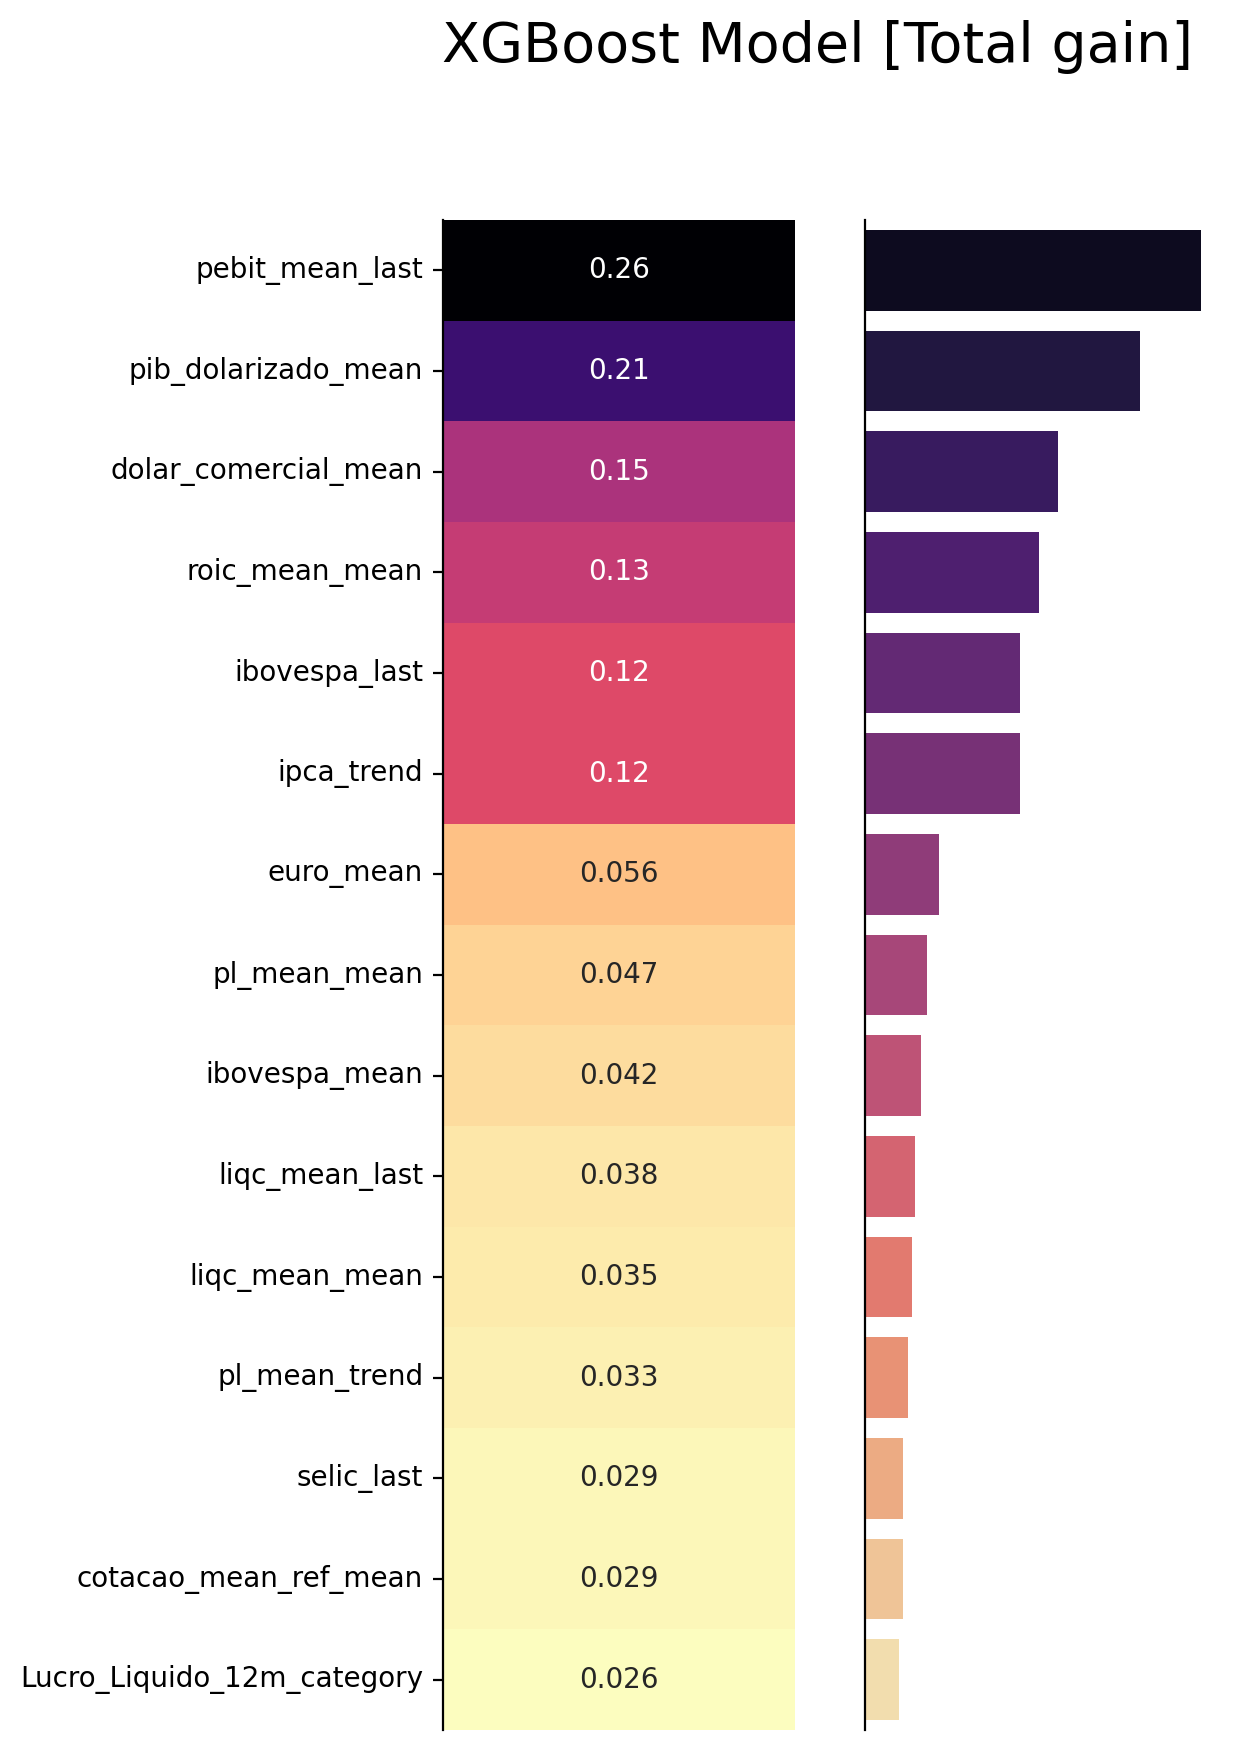

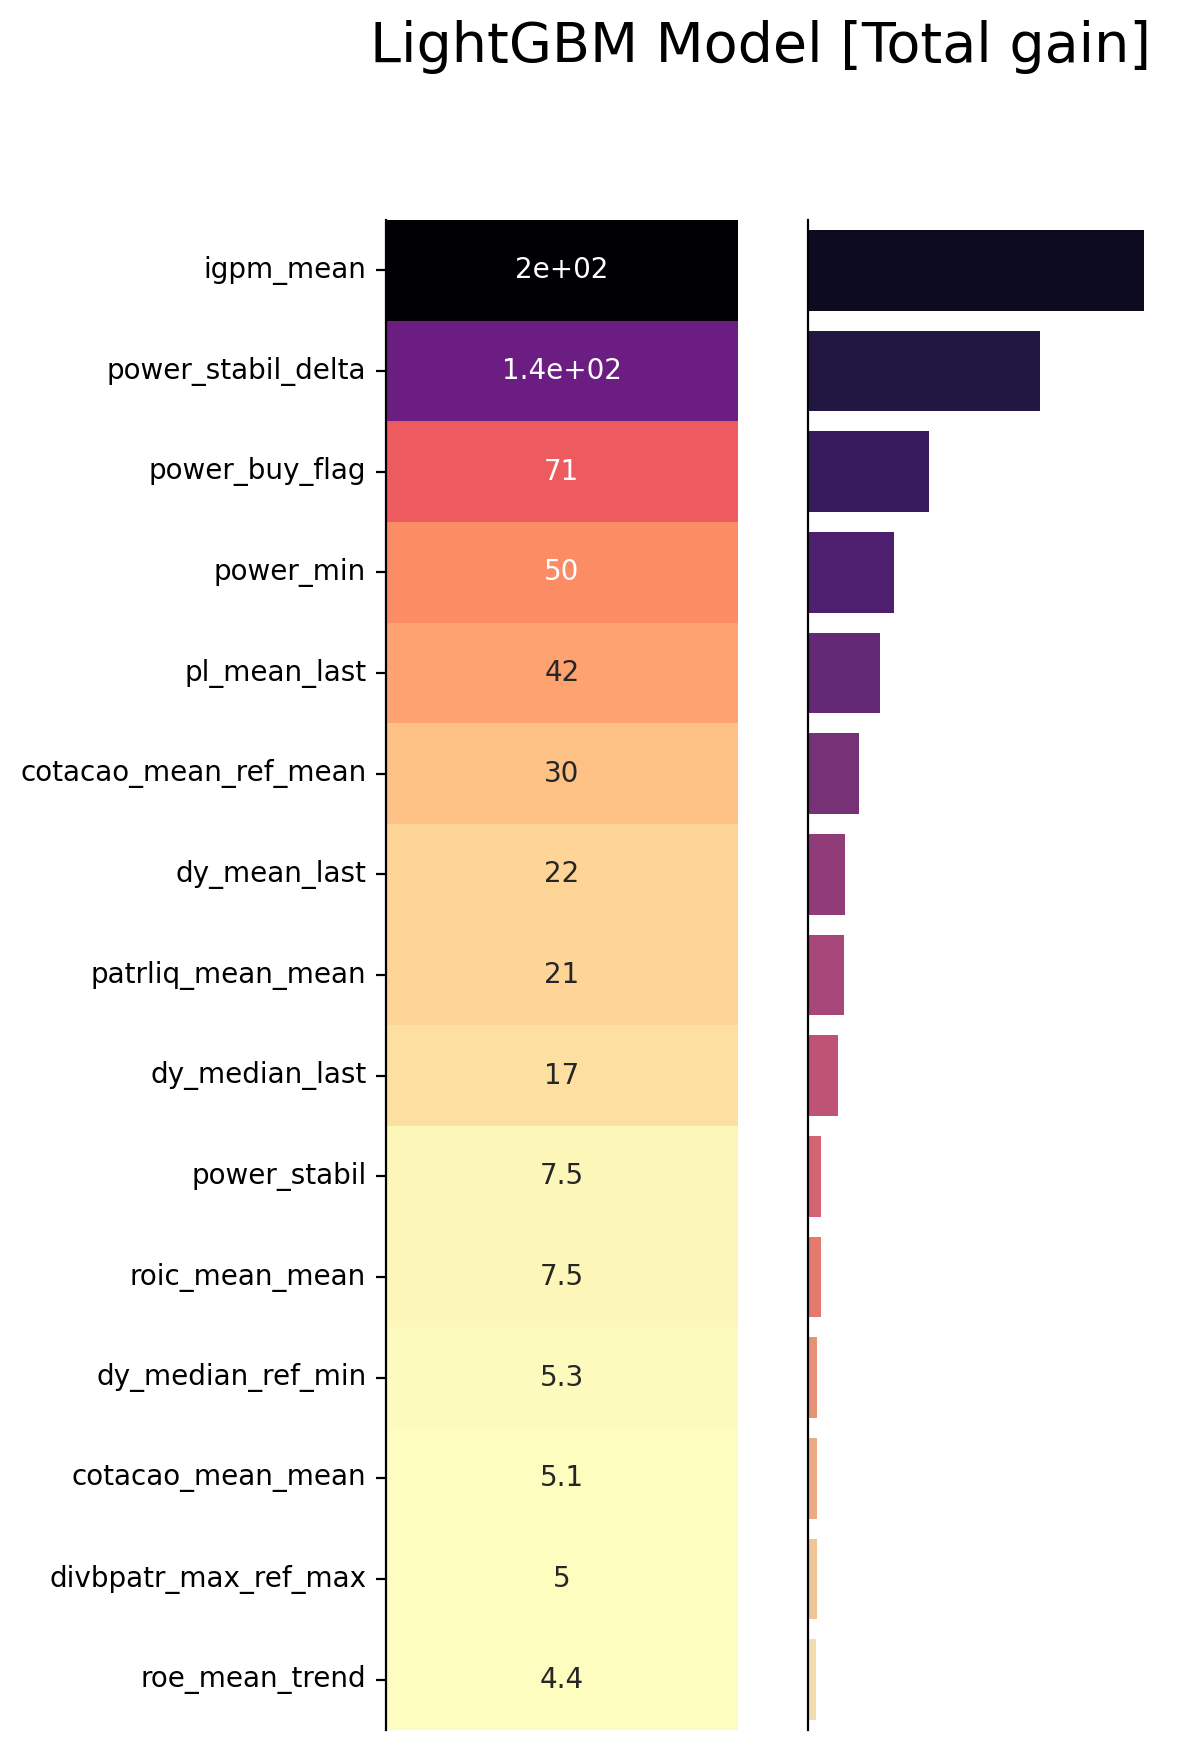

In [26]:
xgb_feature_importance = get_feature_importances(xgb_model, 'XGB', X.columns.to_list())
plot_importance(xgb_feature_importance, 'Total gain', 'XGBoost Model [Total gain]')

lgb_feature_importance = get_feature_importances(lgb_model, 'LGB', X.columns.to_list())
plot_importance(lgb_feature_importance, 'Total gain', 'LightGBM Model [Total gain]')

Get feature importances based on SHAP values

100%|===================| 22825/22833 [10:25<00:00]        

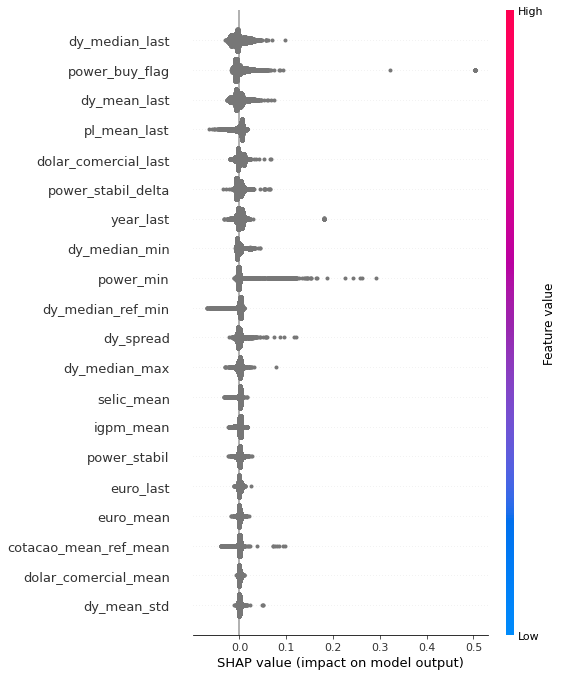

100%|===================| 22821/22833 [06:33<00:00]        

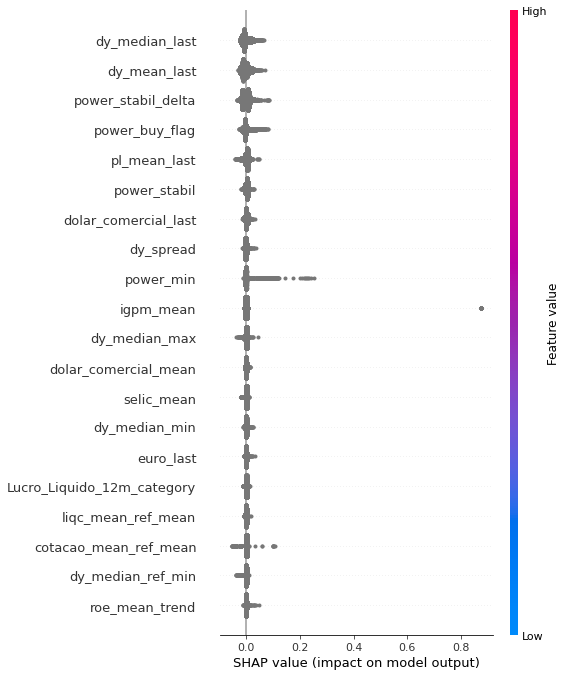

In [27]:
# ref_date = '2023-08-08'
ref_date = date.today()

X = df[xgb_model_features]
y = df['dy_label'].astype('float')
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

path = '../data/03_models/out/'
file_name_shap = f'{ref_date}_XGBRegressor_Normalizer()_SHAP.pkl'

xgb_shap = calculate_shap_values(xgb_model, xgb_model_transformer, X_train, X_test, path, file_name_shap, plot=True)

# Save SHAP values to a file using pickle
with open(path + file_name_shap, 'wb') as file:
    pickle.dump(xgb_shap, file)




X = df[lgb_model_features]
y = df['dy_label'].astype('float')
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=32)

file_name_shap = f'{ref_date}_LGBMRegressor_Normalizer()_SHAP.pkl'

lgb_shap = calculate_shap_values(lgb_model, lgb_model_transformer, X_train, X_test, path, file_name_shap, plot=True)


# Save SHAP values to a file using pickle
with open(path + file_name_shap, 'wb') as file:
    pickle.dump(lgb_shap, file)

In [28]:
d = dict(zip(xgb_model_features,np.abs(np.sum(xgb_shap.values, axis=0))))
df_xgb_shap = pd.DataFrame(d, index=['shap_values']).T.sort_values(by='shap_values', ascending=False)

d = dict(zip(lgb_model_features,np.abs(np.sum(lgb_shap.values, axis=0))))
df_lgb_shap = pd.DataFrame(d, index=['shap_values']).T.sort_values(by='shap_values', ascending=False)

### Train feature selection model

Load baseline models' feature importance

In [29]:
# ref_date = '2023-08-08'
ref_date = date.today()

path = '../data/03_models/out/'


file_name_shap = f'{ref_date}_XGBRegressor_Normalizer()_SHAP.pkl'

with open(path + file_name_shap, 'rb') as file:
        xgb_shap = pickle.load(file)


file_name_shap = f'{ref_date}_LGBMRegressor_Normalizer()_SHAP.pkl'

with open(path + file_name_shap, 'rb') as file:
        lgb_shap = pickle.load(file)

Get the most important features from the XGBoost and LightGBM models, through the intersection of the first 60 features

In [30]:
n = 80

intersection_lgb_xgb = np.isin(df_lgb_shap.iloc[:n].index,df_xgb_shap.iloc[:n].index)
intersection_xgb_lgb = np.isin(df_xgb_shap.iloc[:n].index,df_lgb_shap.iloc[:n].index)
cols_to_train = df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index.to_list()

print('lgb in xgb ',np.mean(intersection_lgb_xgb))
print('xgb in lgb ',np.mean(intersection_xgb_lgb))
print('double check, cross intersection value', 
      np.isin(df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index,df_xgb_shap.iloc[:n].loc[intersection_xgb_lgb].index).mean())
print('\n\ncols to train:\n')
for col in  cols_to_train:
    print(col)

lgb in xgb  0.8125
xgb in lgb  0.8125
double check, cross intersection value 1.0


cols to train:

dy_mean_last
dy_median_last
igpm_mean
dy_spread
power_stabil_delta
power_stabil
dolar_comercial_last
selic_mean
power_buy_flag
pl_mean_last
euro_last
dolar_comercial_mean
dolar_comercial_trend
dy_median_min
pcg_mean_trend
pacl_mean_last
selic_last
dy_median_ref_min
power_min
euro_mean
liqc_mean_ref_mean
year_last
roic_mean_mean
dy_median_max
pvp_mean_mean
cotacao_mean_ref_mean
power_margin
liq2m_mean_mean
divbpatr_mean_last
pacl_mean_mean
pvp_mean_ref_mean
divbpatr_mean_mean
pebit_mean_trend
divbpatr_max_ref_max
pacl_mean_ref_mean
roe_mean_mean
roic_mean_last
liqc_mean_last
roe_mean_trend
mrgebit_mean_last
Lucro_Liquido_12m_category
ibovespa_mean
Tipo_ON
pvp_mean_trend
pa_mean_trend
psr_mean_mean
patrliq_mean_ref_mean
roe_mean_last
mrgliq_mean_mean
mrgliq_mean_last
pcg_mean_mean
pebit_mean_ref_mean
pa_mean_last
cotacao_mean_mean
pvp_mean_last
psr_mean_ref_mean
psr_mean_last
power_price
ip

Train new feature selection model

In [31]:
params_path = '../data/03_models/in/params_optimized_lgbm.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

regressors = {
            'LGBMRegressor':LGBMRegressor(),
            'XGBRegressor':XGBRegressor(),
        }

transformers = [Normalizer(),StandardScaler()]

models = train_models(df, params_path, label, regressors, transformers, 
                        cols_to_train=cols_to_train, 
                        sufix='feat_selection')

here we go again
LGBMRegressor_Normalizer()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([194.73916006, 195.26840687, 195.93895149, 194.12617636,
       198.24445462]), 'score_time': array([0.54312754, 0.54219246, 0.54820752, 0.55113029, 0.56213236]), 'test_r2': array([0.90781868, 0.9173783 , 0.88107507, 0.83778289, 0.89168472]), 'test_mse': array([0.00023242, 0.00022397, 0.00031035, 0.00043481, 0.00032813]), 'test_xve': array([0.90783884, 0.91738021, 0.88108734, 0.83778455, 0.89170338]), 'test_MAPE': array([3.96589058e+12, 3.65018585e+12, 3.95845101e+12, 5.25668827e+12,
       3.92049237e+12])}
CV R2 score: 0.8871479344010655
CV MSE: 0.00030593721684604594
test r2: 0.9121470202251539
test mse: 0.000237279487012492
test explained_variance_score: 0.9121495889442547
test MAPE: 4083944520671.8374
___________________________________

Best Parameters: {'reg__learning_rate': 0.5, 'reg__max_depth': 5, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.9121470202251539
LGBMRe

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([192.64658952, 191.75652981, 195.03924656, 190.87390041,
       190.85080051]), 'score_time': array([0.50611973, 0.4987011 , 0.49711752, 0.50270176, 0.46811032]), 'test_r2': array([0.88652638, 0.89071341, 0.85996297, 0.87792943, 0.85321423]), 'test_mse': array([0.00028611, 0.00029625, 0.00036545, 0.0003272 , 0.00044468]), 'test_xve': array([0.88654682, 0.89071468, 0.85997144, 0.87793053, 0.85322183]), 'test_MAPE': array([4.53777370e+12, 5.02336453e+12, 4.49960076e+12, 4.70070808e+12,
       5.45952996e+12])}
CV R2 score: 0.8736692846962827
CV MSE: 0.0003439362635593972
test r2: 0.9287867517972985
test mse: 0.00019233773339658898
test explained_variance_score: 0.9287869773448826
test MAPE: 3585050849810.3174
___________________________________

Best Parameters: {'reg__learning_rate': 0.5, 'reg__max_depth': 5, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_StandardScaler() 0.9287867517972985


In [32]:
d = dict(zip(xgb_model_features,np.abs(np.sum(xgb_shap.values, axis=0))))
df_xgb_shap = pd.DataFrame(d, index=['shap_values']).T.sort_values(by='shap_values', ascending=False)

d = dict(zip(lgb_model_features,np.abs(np.sum(lgb_shap.values, axis=0))))
df_lgb_shap = pd.DataFrame(d, index=['shap_values']).T.sort_values(by='shap_values', ascending=False)

In [33]:
n = 60

intersection_lgb_xgb = np.isin(df_lgb_shap.iloc[:n].index,df_xgb_shap.iloc[:n].index)
intersection_xgb_lgb = np.isin(df_xgb_shap.iloc[:n].index,df_lgb_shap.iloc[:n].index)
cols_to_train = df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index.to_list()

print('lgb in xgb ',np.mean(intersection_lgb_xgb))
print('xgb in lgb ',np.mean(intersection_xgb_lgb))
print('double check, cross intersection value', 
      np.isin(df_lgb_shap.iloc[:n].loc[intersection_lgb_xgb].index,df_xgb_shap.iloc[:n].loc[intersection_xgb_lgb].index).mean())
print('\n\ncols to train:\n')
for col in  cols_to_train:
    print(col)

lgb in xgb  0.7666666666666667
xgb in lgb  0.7666666666666667
double check, cross intersection value 1.0


cols to train:

dy_mean_last
dy_median_last
igpm_mean
dy_spread
power_stabil_delta
power_stabil
dolar_comercial_last
selic_mean
power_buy_flag
pl_mean_last
euro_last
dolar_comercial_mean
dolar_comercial_trend
dy_median_min
pcg_mean_trend
pacl_mean_last
selic_last
dy_median_ref_min
power_min
euro_mean
liqc_mean_ref_mean
year_last
roic_mean_mean
dy_median_max
pvp_mean_mean
cotacao_mean_ref_mean
power_margin
liq2m_mean_mean
divbpatr_mean_last
pacl_mean_mean
pvp_mean_ref_mean
divbpatr_mean_mean
pebit_mean_trend
divbpatr_max_ref_max
roe_mean_mean
roic_mean_last
liqc_mean_last
roe_mean_trend
mrgebit_mean_last
Lucro_Liquido_12m_category
ibovespa_mean
Tipo_ON
pvp_mean_trend
patrliq_mean_ref_mean
roe_mean_last
pebit_mean_ref_mean


In [34]:
params_path = '../data/03_models/in/params_optimized_lgbm.json'

cols_to_drop = ['year_month','Papel','Empresa','dy_label']
label = ['dy_label']

regressors = {
            'LGBMRegressor':LGBMRegressor(),
        }

transformers = [Normalizer(),StandardScaler()]

models = train_models(df, params_path, label, regressors, transformers, 
                        cols_to_train=cols_to_train, 
                        sufix='feat_selection_lgbm')

here we go again
LGBMRegressor_Normalizer()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([143.39565563, 143.40970874, 142.70560503, 142.0673418 ,
       142.29813838]), 'score_time': array([0.41972709, 0.41909862, 0.40818   , 0.39416265, 0.42209888]), 'test_r2': array([0.91010281, 0.92005076, 0.87410742, 0.8363498 , 0.8878433 ]), 'test_mse': array([0.00022666, 0.00021672, 0.00032854, 0.00043865, 0.00033977]), 'test_xve': array([0.91012115, 0.92005352, 0.8741232 , 0.83635145, 0.88786786]), 'test_MAPE': array([3.86485532e+12, 3.68530399e+12, 4.00026197e+12, 5.21380721e+12,
       3.96800275e+12])}
CV R2 score: 0.8856908175118076
CV MSE: 0.00031006889247850585
test r2: 0.9148962833961922
test mse: 0.00022985408429356127
test explained_variance_score: 0.9148974665267108
test MAPE: 3913956791642.6743
___________________________________

Best Parameters: {'reg__learning_rate': 0.5, 'reg__max_depth': 5, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_Normalizer() 0.9148962833961922
LGBM

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'fit_time': array([142.24773002, 142.4102447 , 141.47342682, 140.96235633,
       142.55168867]), 'score_time': array([0.36208606, 0.36308646, 0.3540833 , 0.35208297, 0.36408615]), 'test_r2': array([0.91353086, 0.92606093, 0.88206098, 0.84764488, 0.8963964 ]), 'test_mse': array([0.00021802, 0.00020043, 0.00030778, 0.00040838, 0.00031386]), 'test_xve': array([0.91354259, 0.92606348, 0.88206771, 0.84765226, 0.8964037 ]), 'test_MAPE': array([4.10334043e+12, 3.65541009e+12, 4.01506386e+12, 5.69601599e+12,
       4.14016710e+12])}
CV R2 score: 0.8931388090707143
CV MSE: 0.0002896932679722283
test r2: 0.9175633809364613
test mse: 0.00022265060027071754
test explained_variance_score: 0.9175641196569988
test MAPE: 4209762345191.4614
___________________________________

Best Parameters: {'reg__learning_rate': 0.5, 'reg__max_depth': 3, 'reg__n_estimators': 1000, 'reg__reg_alpha': 0.1, 'reg__reg_lambda': 0.01}
##################################
LGBMRegressor_StandardScaler() 0.9175633809364613
